## A Very Simple ``Dash`` App

In [1]:
from dash import Dash, html, Output, Input

app = Dash()

app.layout = html.Div([
    html.H1("A Simple App", id="title"),
    html.P("Structure things like you would in HTML"),
    html.Button("Click me to do something", id="button")
])

@app.callback(
    Output("title", "children"), # change this value
    Input("button", "n_clicks"), # when this changes
    prevent_initial_call = True
)
def update_title_on_buttonclick(n_clicks):
    print(n_clicks) # sure why not
    return "A Simple App **That Does Things!**"

app.run()

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_9_2m1680375717.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_9_2m1680375717.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_9_2m1680375717.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_9_2m1680375717.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_9_1m1680375717.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-suites/dash/dcc/dash_core_components-shared.v2_9_1m1680375717.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:53] "GET /_dash-component-su

1


127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


2


127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:17:57] "POST /_dash-update-component HTTP/1.1" 200 -


3
4


127.0.0.1 - - [22/Apr/2023 21:17:58] "POST /_dash-update-component HTTP/1.1" 200 -


5


## A Bit More Complicated App

Let's use bootstrap to spruce this up a bit

In [3]:
import dash_bootstrap_components as dbc

app = Dash(external_stylesheets=[dbc.themes.SKETCHY])

app.layout = html.Div([
    dbc.NavbarSimple(brand="Communities in Network Graphs"),
    dbc.Container([
        dbc.Row([
            dbc.Col(
                "Hello", width=3
            ),
            dbc.Col("Everyone", width=9)
        ])
    ])
])

app.run()


Dash is running on http://127.0.0.1:8050/

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:8050
Press CTRL+C to quit
127.0.0.1 - - [22/Apr/2023 21:22:24] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:25] "GET /_dash-component-suites/dash_bootstrap_components/_components/dash_bootstrap_components.v1_4_1m1682212359.min.js HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [22/Apr/2023 21:22:26] "GET /_favicon.ico?v=2.9.2 HTTP/1.1" 200 -


## Cytoscape

Now we can use the `dash-cytoscape` package to display our graph. Let's start with wireframe layout and then add in the functionality we need:

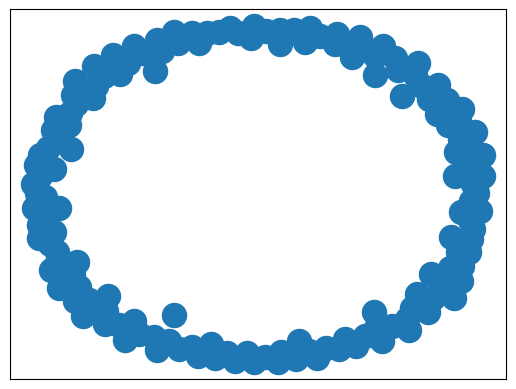

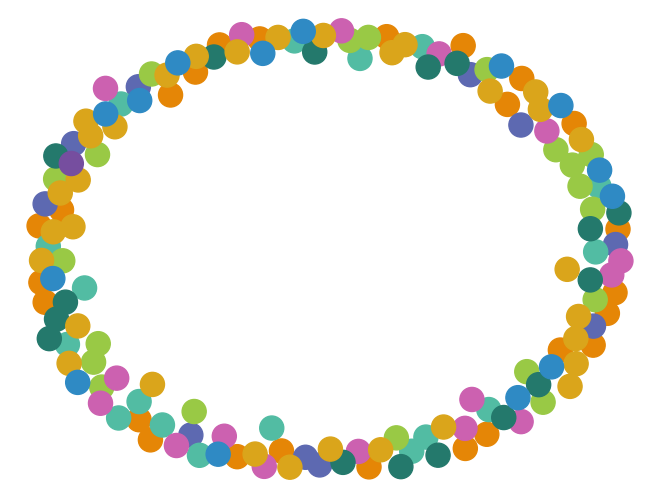

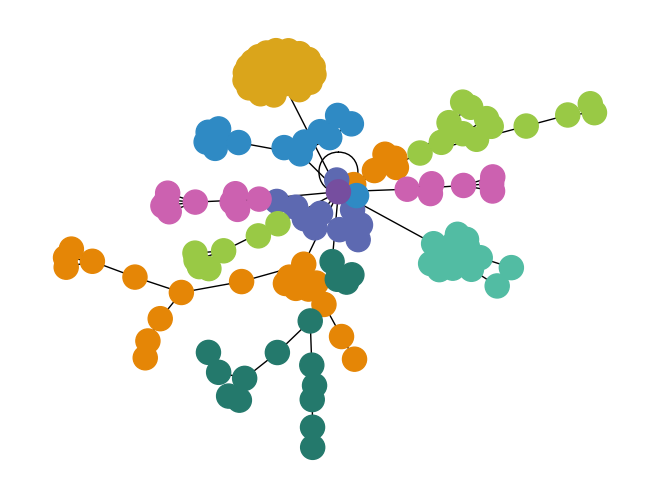

Coercing column 'status' to `list`
Coercing column 'languages' to `list`
Coercing column 'status' to `list`
Coercing column 'languages' to `list`
{'Ryan Smith': {'Python', 'Java', 'JavaScript'}, 'Joshua Kirk': {'JavaScript'}, 'Jennifer Nolan': {'Java', 'JavaScript'}, 'Benjamin Jennings': {'Go'}, 'Rhonda Taylor': {'Scala'}, 'Amber Gutierrez': {'JavaScript'}, 'Malik Jackson': {'Python', 'Scala'}, 'Jacqueline Cook': {'Java', 'Scala', 'Go', 'JavaScript', 'Python'}, 'Ashley Davis': {'Python', 'Go'}, 'Matthew Liu': {'Typescript', 'Java'}, 'Samantha Garcia': {'Go', 'Java'}, 'Melissa Sloan': {'Typescript', 'JavaScript'}, 'Timothy Williams': {'Python'}, 'Patricia Cowan': {'Typescript', 'Python', 'JavaScript', 'Scala'}, 'Katherine Grant': {'Python', 'JavaScript'}, 'Nichole Spencer': {'Python', 'Java', 'JavaScript'}, 'Linda Foster': {'Go'}, 'Charles Schmidt': {'Java'}, 'Jorge Deleon': {'Python', 'JavaScript'}, 'John Anderson': {'Typescript', 'Java'}, 'Donald Jones': {'Python', 'JavaScript', 'Erla

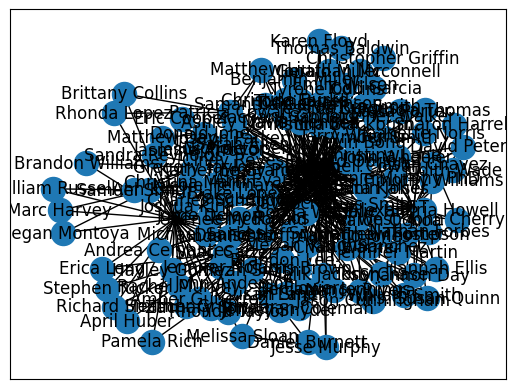

In [2]:
%run "../Part 2 - Clustered Graph Attributes/Solution.ipynb"

NodeView(('Ryan Smith', 'Joshua Kirk', 'Jennifer Nolan', 'Daniel Burnett', 'Benjamin Jennings', 'Rhonda Taylor', 'Amber Gutierrez', 'Malik Jackson', 'Pamela Rich', 'Jacqueline Cook', 'Ashley Davis', 'Jesse Murphy', 'Nathan Forbes', 'Matthew Liu', 'Samantha Garcia', 'Melissa Sloan', 'Timothy Williams', 'George Alexander', 'Patricia Cowan', 'Katherine Grant', 'Deborah Bartlett', 'Rhonda Lopez', 'Brittany Collins', 'Nichole Spencer', 'Linda Foster', 'Charles Schmidt', 'Jorge Deleon', 'John Anderson', 'Donald Jones', 'Ann Evans', 'Michael Sanchez', 'Denise Hoffman', 'Zachary Snyder', 'Matthew Day', 'Andrea Cervantes', 'Daniel Johnson', 'Todd Ferrell', 'Benjamin Miller', 'Todd Garcia', 'Christina Blackburn', 'Karen Floyd', 'Jonathan Mcconnell', 'Mario Mendez', 'Christina Burke', 'Emily Wilson', 'Jessica Burgess', 'Thomas Baldwin', 'Michael Brown', 'Philip Bell', 'Zachary Sanders', 'Charles Rodriguez', 'Lisa French', 'Louis Smith', 'John West', 'Christina Lane', 'Melanie Murphy PhD', 'Edward

In [3]:
elements = (
    nx.cytoscape_data(G)["elements"]["nodes"]
    + nx.cytoscape_data(G)["elements"]["edges"]
)

In [5]:
stylesheet = [
    # Group selectors
    {"selector": "node", "style": {"content": "data(label)", "width":"data(size)", "height":"data(size)"}},
    {"selector": """[stream = "Academia"]""", "style":{"background-color":"blue"}},
    {"selector": """[stream = "Curation"]""", "style":{"background-color":"green"}},
    # Edge selectors
    {
        "selector": "edge",
        "style": {
            "content": "data(label)",
            "curve-style": "bezier",
            "line-color": "gray",
            "source-arrow-shape":"triangle",
            "font-size":"10px",
        },
    },
]

In [10]:
from dash import dash, html, dcc, Input, Output
# from jupyter_dash import JupyterDash
import dash_cytoscape as cyto
# JupyterDash.infer_jupyter_proxy_config()
cyto.load_extra_layouts()
dashboard = dash.Dash(__name__)
#dashboard = JupyterDash(__name__)

lyt = "cose-bilkent"
#lyt = "spread"
#lyt = "klay"

def layout():
    network = cyto.Cytoscape(
        id="network",
        layout={"name": lyt},
        style={"width": "100%", "height": "800px"},
        elements=elements,
        #stylesheet=stylesheet
    )
    return html.Div([
        html.H1("The Network"),
        network
    ])


dashboard.layout = layout
dashboard.run(port=16900, debug=True, use_reloader=False)

Dash is running on http://127.0.0.1:16900/

 * Serving Flask app '__main__'
 * Debug mode: on
